In [1]:
# i always dreamed of being a half-man half-horse
# freely roaming the meadows on my own two feet
#                                            -Kai
#
# github.com/kaibrooks

In [2]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from keras.optimizers import RMSprop
from keras.optimizers import Adam 
from keras.utils.data_utils import get_file
from keras.layers import Dropout # dropout crew 4 lyf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # resizes input images
from IPython.display import clear_output # clear plot after each epoch
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import scipy
import random
import sys
import io
import os
import h5py 
import PIL # this imports Pillow, but for some dumb reason needs 'PIL'
from PIL import Image # displays images for training
import matplotlib.pyplot as plt # fancy plots
from matplotlib import pyplot as plt
from datetime import datetime # so we know how much time we've wasted


class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.title('training in progress')
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()


# might be good to know
print('TensorFlow version', tf.__version__)
print('Keras version', keras.__version__)
print('SciPy version', scipy.__version__)
print('Numpy version', np.__version__) 
print('Pillow version', PIL.__version__) 

Using TensorFlow backend.


TensorFlow version 2.0.0
Keras version 2.2.4-tf
SciPy version 1.4.1
Numpy version 1.18.0
Pillow version 6.2.1


In [3]:
## set up some parameters
source = 'horseman' # name of the source
class_names = ['horse','human'] # classes this makes up
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
num_classes = 2 # 2: how many classes we're detecting (horse/human)
imsize = 64 # 64: resize images to exactly this, larger takes longer and looks at more detail

num_classes = len(class_names) # how many classes the dataset has

# all the settings
batch_size = 16  # 16?
epochs = 100 # 100

# other settings
num_predictions = 20 # 20
use_multiprocessing = False # F parallelize or not
workers = 1 # 1 workers to use for training
threadSafe = False # F make thread safe, sometimes produces errors

# save locations
save_dir = os.path.join(os.getcwd(), 'trained_models')
plot_dir = os.path.join(os.getcwd(), 'plots')

# make sure these folders exist
if not os.path.exists(save_dir): os.mkdir(save_dir)
if not os.path.exists(plot_dir): os.mkdir(plot_dir)

In [4]:
## load the data
print('Getting data from', os.getcwd())
datagen = ImageDataGenerator(rescale = 1. / 255) # force images to be square

# load and iterate training dataset
print('Train: ')
train_it = datagen.flow_from_directory('data/train/', class_mode='categorical', batch_size=batch_size, target_size=(imsize, imsize))

# load and iterate validation dataset
print('Validate: ')
val_it = datagen.flow_from_directory('data/validation/', class_mode='categorical', batch_size=batch_size, target_size=(imsize, imsize))

# load and iterate test dataset
print('Test:')
test_it = datagen.flow_from_directory('data/test/', class_mode='categorical', batch_size=batch_size, target_size=(imsize, imsize))



Getting data from /tf/notebooks/multi-ml/docker_files/demo-horseman
Train: 
Found 992 images belonging to 2 classes.
Validate: 
Found 199 images belonging to 2 classes.
Test:
Found 256 images belonging to 2 classes.


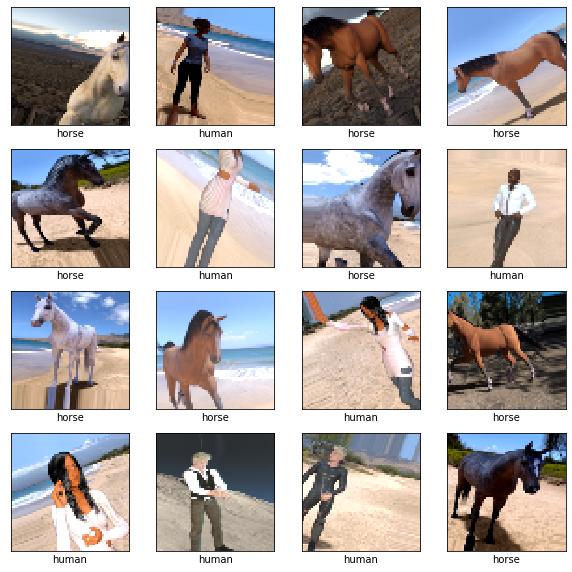

If this image isn't 100% correct, some images are in the wrong folder and the entire training will be a waste


In [5]:
(train_images, train_labels) = train_it.next()
plt.figure(figsize=(10,10))
for i in range(batch_size):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(train_labels[i])]) # int because class number is normally a float
    #plt.xlabel(train_labels[i])
plt.show()
print('If this image isn\'t 100% correct, some images are in the wrong folder and the entire training will be a waste')

In [6]:
## set up model
model = Sequential()

# input layer
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_images.shape[1:])) # filters, kernel size
model.add(Activation('relu'))
model.add(Dropout(0.0))

# hidden layers
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output (convergence) layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

print('Model summary:')
model.summary()

print('Ready to train')

Model summary:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 31,

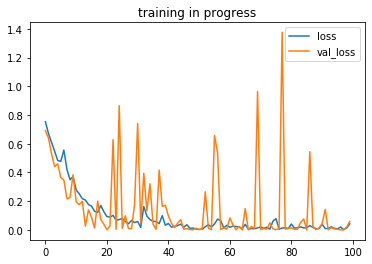

Finished training at 07-Jan-2020 23:45:23
Test loss: 3.4094347953796387
Test accuracy: 0.8125


In [7]:
## train me
now = datetime.now()
runDate = now.strftime("%Y-%m-%d_%H-%M-%S")
print("Starting training at", now.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this takes

# early stopping parameters
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=round(epochs*1.2)) # stop early if no progress for some % of max epochs

# callbacks to save the best model
mc1 = ModelCheckpoint('trained_models/best_model.h5', monitor='loss', mode='min', save_best_only=True)
mc2 = ModelCheckpoint('trained_models/last_model.h5') # save model each run

# fit model
history = model.fit_generator(train_it, 
                    epochs=epochs, 
#                    steps_per_epoch=16, 
                    validation_data=val_it, 
                    validation_steps=8,
                    workers=workers,
                    callbacks=[es, mc1, mc2, plot_losses])

(x_test, y_test) = val_it.next()

then = datetime.now()
print("Finished training at", then.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this took


## score trained model
(test_images, test_labels) = test_it.next()
scores = model.evaluate(test_images, test_labels, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [8]:
## save models and log

# this is where you pay attention to where you mapped the Docker dir to your local dir at run
save_dir = os.path.join(os.getcwd(), 'trained_models')

if not os.path.isdir(save_dir): # make dir if it doesn't exist
    os.makedirs(save_dir)    
    print(save_dir, 'doesn\'t exist, creating it')

print('Saving...') # do this because saving the model takes 5+ seconds sometimes


# name the files
last_name =  source + '_e' + str(epochs) + '_' + runDate + '_trainedmodel_last.h5'
summary_name = source + '_e' + str(epochs) + '_' + runDate + '_modelsummary.txt'
best_name = source + '_e' + str(epochs) + '_' + runDate + '_trainedmodel_best.h5'
weights_name = source + '_e' + str(epochs) + '_' + runDate + '_trainedmodel_weights.h5' # for weights only



# get the best model
saved_model = load_model('trained_models/best_model.h5')

# save best model
model_path = os.path.join(save_dir, best_name)
saved_model.save(model_path)

# save weights only
model_path = os.path.join(save_dir, weights_name)
saved_model.save_weights(model_path)

# save summary
with open(os.path.join(save_dir, summary_name),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))


print('Saved to ', os.path.join(save_dir), 'as', runDate)
#print('Saved best model at %s ' % os.path.join(save_dir, best_name)) 
#print('Saved summary at %s' % os.path.join(save_dir, summary_name))   


size = os.path.getsize(os.path.join(save_dir, best_name)) # note how big the model is because they're often huge
print('Model file is',round(size/1e+6),'MB')
size = os.path.getsize(model_path) # note how big the model is because they're often huge
print('Weights file is',round(size/1e+6),'MB')

Saving...
Saved to  /tf/notebooks/multi-ml/docker_files/demo-horseman/trained_models as 2020-01-07_23-39-50
Model file is 78 MB
Weights file is 26 MB


In [9]:
## score trained model
(test_images, test_labels) = test_it.next()
scores = model.evaluate(test_images, test_labels, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.03444984182715416
Test accuracy: 1.0


In [10]:
## make a predictions
predictions = model.predict(test_images) # load the data
predictions[0] # predict the [0]th element, this outputs an array with each element being the confidence of being that class
print('Class confidence for image 0:', predictions[0])
print('\nPrediction  :', np.argmax(predictions[0])) # output the most likely prediction
print('Actual class:', np.argmax(test_labels))  # output what the answer actually is)

Class confidence for image 0: [5.664223e-21 1.000000e+00]

Prediction  : 1
Actual class: 1


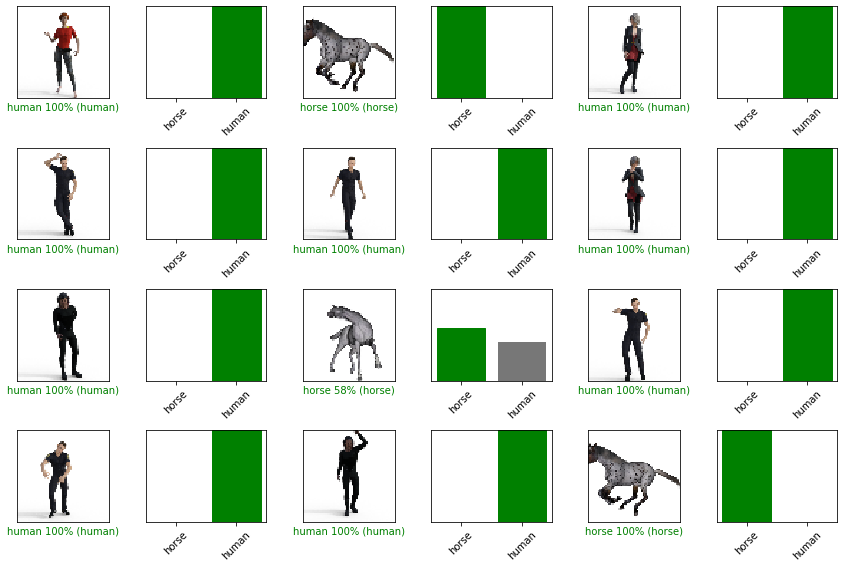

In [11]:
## make a pinterest board of images and their classifications
# set up first
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, np.argmax(true_label[i])
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[int(true_label)].set_color('green')

## plot a single image and its prediction
#i = 0
#plt.figure(figsize=(6,3))
#plt.subplot(1,2,1)
#plot_image(i, predictions[i], test_labels, test_images)
#plt.subplot(1,2,2)
#plot_value_array(i, predictions[i],  test_labels)
#plt.show()

# lets do another
#i = 12
#plt.figure(figsize=(6,3))
#plt.subplot(1,2,1)
#plot_image(i, predictions[i], test_labels, test_images)
#plt.subplot(1,2,2)
#plot_value_array(i, predictions[i],  test_labels)
#plt.show()

## show a bunch of predicted images and display a grid
num_rows = 4 # increase this to show more
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
  _ = plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.tight_layout()
plt.show()

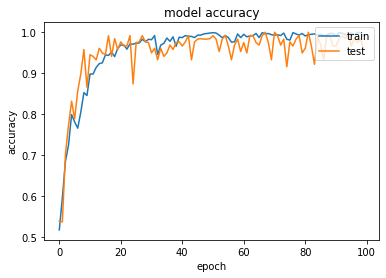

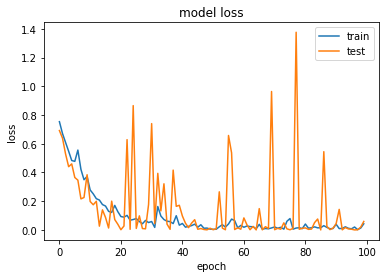

Max accuracy: 1.0
Min loss: 0.0024093095891800894


In [12]:
## plot training information
# accuracy
accuracy_max = np.max(history.history['accuracy'])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(os.path.join('plots',source + '_' + runDate + '_accuracy.png'))

plt.show()

# loss
loss_min = np.min(history.history['loss'])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(os.path.join('plots',source + '_' + runDate + '_loss.png'))



plt.show()

print('Max accuracy:', str(accuracy_max))
print('Min loss:', str(loss_min))